In [1]:
import pandas as pd
test_df = pd.read_csv('predictions.csv')



In [2]:
print(test_df.head(5))
print(test_df.shape)
print(test_df.columns)


                                        image_base64 label prediction
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQ...     A          S
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQ...     A          A
2  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQ...     A          A
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQ...     A          A
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAIBAQEBAQIBAQ...     A          A
(780, 3)
Index(['image_base64', 'label', 'prediction'], dtype='object')


In [6]:
len(test_df['prediction'].value_counts())

22

In [7]:
len(test_df['label'].value_counts())

26

In [11]:
print("Number of classes in training", len(test_df['label'].value_counts()))
print("Number of classes in prediction", len(test_df['prediction'].value_counts()))
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
prediction = test_df['prediction'].value_counts().index.tolist()

Number of classes in training 26
Number of classes in prediction 22


In [29]:
# Find missing classes in prediction
missing_classes = [cls for cls in labels if cls not in prediction]
print("Missing classes in prediction:", missing_classes)
print("Number of missing classes:", len(missing_classes))


Missing classes in prediction: ['M', 'N', 'Q', 'Z']
Number of missing classes: 4


In [28]:
# print("Label classes count",test_df['label'].value_counts().sort_index())
# Create a DataFrame with classes and their counts
label_counts = test_df['label'].value_counts().sort_index()
prediction_counts = test_df['prediction'].value_counts().sort_index()

# Get all unique classes from both labels and predictions
all_classes = sorted(set('ABCDEFGHIJKLMNOPQRSTUVWXYZ'))

# Create the comparison DataFrame
comparison_df = pd.DataFrame({
    'class': all_classes,
    'label_count': [label_counts.get(cls, 0) for cls in all_classes],
    'prediction_count': [prediction_counts.get(cls, 0) for cls in all_classes]
})

print("Classes comparison:")
print(comparison_df)


Classes comparison:
   class  label_count  prediction_count
0      A           30                68
1      B           30                28
2      C           30                40
3      D           30               111
4      E           30                 6
5      F           30               100
6      G           30                11
7      H           30                 1
8      I           30                73
9      J           30                 1
10     K           30                 4
11     L           30                39
12     M           30                 0
13     N           30                 0
14     O           30                 1
15     P           30                 1
16     Q           30                 0
17     R           30                18
18     S           30                87
19     T           30                 3
20     U           30                88
21     V           30                40
22     W           30                34
23     X           3

In [14]:
print("Classes in trainig", sorted(labels))
print("Classes in prediction",(sorted(prediction)))

Classes in trainig ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Classes in prediction ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from collections import Counter
from datetime import datetime

In [70]:
def evaluate_asl_predictions(results_df):
    """
    Comprehensive evaluation of ASL classification results
    
    Args:
        results_df: DataFrame with 'label' (true) and 'prediction' columns
    
    Returns:
        Dictionary with all evaluation metrics
    """
    
    # Basic metrics
    y_true = results_df['label']
    y_pred = results_df['prediction']
    
    # Remove any failed predictions ("?") for cleaner analysis
    valid_mask = (y_pred != "?") & (y_true != "?") & (~pd.isna(y_pred)) & (~pd.isna(y_true))
    y_true_clean = y_true[valid_mask]
    y_pred_clean = y_pred[valid_mask]
    
    print("="*60)
    print("🔍 ASL CLASSIFICATION EVALUATION RESULTS")
    print("="*60)
    
    # 1. OVERALL ACCURACY
    overall_accuracy = accuracy_score(y_true_clean, y_pred_clean)
    failed_predictions = (~valid_mask).sum()
    
    print(f"\n📊 OVERALL METRICS:")
    print(f"   Total Images: {len(results_df)}")
    print(f"   Valid Predictions: {len(y_true_clean)} ({len(y_true_clean)/len(results_df)*100:.1f}%)")
    print(f"   Failed Predictions: {failed_predictions} ({failed_predictions/len(results_df)*100:.1f}%)")
    print(f"   Overall Accuracy: {overall_accuracy:.3f} ({overall_accuracy*100:.1f}%)")
    
    # 2. PER-CLASS ACCURACY
    print(f"\n PER-LETTER ACCURACY:")
    per_class_accuracy = {}
    letters_list = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    
    for letter in sorted(letters_list):
        letter_mask = y_true_clean == letter
        if letter_mask.sum() > 0:
            letter_accuracy = (y_true_clean[letter_mask] == y_pred_clean[letter_mask]).mean()
            per_class_accuracy[letter] = letter_accuracy
            print(f"   {letter}: {letter_accuracy:.3f} ({letter_accuracy*100:.1f}%)")
    
     # 3. BEST AND WORST PERFORMING LETTERS
    if per_class_accuracy:
        sorted_accuracy = sorted(per_class_accuracy.items(), key=lambda x: x[1], reverse=True)
        print(f"\n🏆 BEST PERFORMING LETTERS:")
        for letter, acc in sorted_accuracy[:5]:
            print(f"   {letter}: {acc:.3f} ({acc*100:.1f}%)")
        
        print(f"\n⚠️  WORST PERFORMING LETTERS:")
        for letter, acc in sorted_accuracy[-5:]:
            print(f"   {letter}: {acc:.3f} ({acc*100:.1f}%)")

    # 4. CONFUSION ANALYSIS
    print(f"\n🔄 MOST COMMON MISCLASSIFICATIONS:")
    confusion_pairs = []
    for i in range(len(y_true_clean)):
        if y_true_clean.iloc[i] != y_pred_clean.iloc[i]:
            confusion_pairs.append((y_true_clean.iloc[i], y_pred_clean.iloc[i]))
    
    common_mistakes = Counter(confusion_pairs).most_common(30)
    for (true_letter, pred_letter), count in common_mistakes:
        print(f"   {true_letter} → {pred_letter}: {count} times")

    # 5. DETAILED CLASSIFICATION REPORT
    print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
    try:
        report = classification_report(y_true_clean, y_pred_clean, zero_division=0)
        print(report)
    except Exception as e:
        print(f"Could not generate classification report: {e}")
    
    return {
        'overall_accuracy': overall_accuracy,
        'per_class_accuracy': per_class_accuracy,
        'failed_predictions': failed_predictions
    }

In [65]:
evaluate_asl_predictions(test_df)

🔍 ASL CLASSIFICATION EVALUATION RESULTS

📊 OVERALL METRICS:
   Total Images: 780
   Valid Predictions: 780 (100.0%)
   Failed Predictions: 0 (0.0%)
   Overall Accuracy: 0.359 (35.9%)

 PER-LETTER ACCURACY:
   A: 0.767 (76.7%)
   B: 0.800 (80.0%)
   C: 0.933 (93.3%)
   D: 0.333 (33.3%)
   E: 0.000 (0.0%)
   F: 0.900 (90.0%)
   G: 0.067 (6.7%)
   H: 0.000 (0.0%)
   I: 0.233 (23.3%)
   J: 0.000 (0.0%)
   K: 0.033 (3.3%)
   L: 0.900 (90.0%)
   M: 0.000 (0.0%)
   N: 0.000 (0.0%)
   O: 0.033 (3.3%)
   P: 0.000 (0.0%)
   Q: 0.000 (0.0%)
   R: 0.500 (50.0%)
   S: 0.733 (73.3%)
   T: 0.000 (0.0%)
   U: 0.800 (80.0%)
   V: 0.733 (73.3%)
   W: 0.867 (86.7%)
   X: 0.000 (0.0%)
   Y: 0.700 (70.0%)
   Z: 0.000 (0.0%)

🏆 BEST PERFORMING LETTERS:
   C: 0.933 (93.3%)
   F: 0.900 (90.0%)
   L: 0.900 (90.0%)
   W: 0.867 (86.7%)
   B: 0.800 (80.0%)

⚠️  WORST PERFORMING LETTERS:
   P: 0.000 (0.0%)
   Q: 0.000 (0.0%)
   T: 0.000 (0.0%)
   X: 0.000 (0.0%)
   Z: 0.000 (0.0%)

🔄 MOST COMMON MISCLASSIFICATIONS

{'overall_accuracy': 0.358974358974359,
 'per_class_accuracy': {'A': np.float64(0.7666666666666667),
  'B': np.float64(0.8),
  'C': np.float64(0.9333333333333333),
  'D': np.float64(0.3333333333333333),
  'E': np.float64(0.0),
  'F': np.float64(0.9),
  'G': np.float64(0.06666666666666667),
  'H': np.float64(0.0),
  'I': np.float64(0.23333333333333334),
  'J': np.float64(0.0),
  'K': np.float64(0.03333333333333333),
  'L': np.float64(0.9),
  'M': np.float64(0.0),
  'N': np.float64(0.0),
  'O': np.float64(0.03333333333333333),
  'P': np.float64(0.0),
  'Q': np.float64(0.0),
  'R': np.float64(0.5),
  'S': np.float64(0.7333333333333333),
  'T': np.float64(0.0),
  'U': np.float64(0.8),
  'V': np.float64(0.7333333333333333),
  'W': np.float64(0.8666666666666667),
  'X': np.float64(0.0),
  'Y': np.float64(0.7),
  'Z': np.float64(0.0)},
 'failed_predictions': np.int64(0)}

In [74]:
def plot_evaluation_results(results_df, save_plots=True):
    """
    Create visualization plots for evaluation results
    """
    y_true = results_df['label']
    y_pred = results_df['prediction']
    
    # Remove failed predictions
    valid_mask = (y_pred != "?") & (y_true != "?") & (~pd.isna(y_pred)) & (~pd.isna(y_true))
    y_true_clean = y_true[valid_mask]
    y_pred_clean = y_pred[valid_mask]
    
    if len(y_true_clean) == 0:
        print("⚠️ No valid predictions to plot!")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('ASL Classification Evaluation Results', fontsize=16, fontweight='bold')
    
    # 1. Confusion Matrix (simplified for readability)
    letters_in_data = sorted(list(set(y_true_clean) | set(y_pred_clean)))
    cm = confusion_matrix(y_true_clean, y_pred_clean, labels=letters_in_data)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=letters_in_data, yticklabels=letters_in_data, ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    
    # 2. Per-class Accuracy
    per_class_acc = {}
    for letter in letters_in_data:
        letter_mask = y_true_clean == letter
        if letter_mask.sum() > 0:
            per_class_acc[letter] = (y_true_clean[letter_mask] == y_pred_clean[letter_mask]).mean()
    
    if per_class_acc:
        letters = list(per_class_acc.keys())
        accuracies = list(per_class_acc.values())
        
        bars = axes[0,1].bar(letters, accuracies, color='skyblue', alpha=0.7)
        axes[0,1].set_title('Per-Letter Accuracy')
        axes[0,1].set_xlabel('Letters')
        axes[0,1].set_ylabel('Accuracy')
        axes[0,1].set_ylim(0, 1)
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, acc in zip(bars, accuracies):
            if bar.get_height() > 0:
                axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                              f'{acc:.2f}', ha='center', va='bottom', fontsize=8)
    
    # 3. Sample Distribution
    true_counts = y_true_clean.value_counts().sort_index()
    axes[1,0].bar(true_counts.index, true_counts.values, color='lightgreen', alpha=0.7)
    axes[1,0].set_title('Sample Distribution by Letter')
    axes[1,0].set_xlabel('Letters')
    axes[1,0].set_ylabel('Number of Samples')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Overall Statistics
    overall_acc = accuracy_score(y_true_clean, y_pred_clean)
    failed_preds = len(results_df) - len(y_true_clean)
    
    stats_text = f"""Overall Statistics:
        Total Images: {len(results_df)}
        Valid Predictions: {len(y_true_clean)}
        Failed Predictions: {failed_preds}
        Overall Accuracy: {overall_acc:.3f}

        Letters Evaluated: {len(letters_in_data)}
        Unique True Labels: {len(set(y_true_clean))}
        Unique Predictions: {len(set(y_pred_clean))}"""
    
    axes[1,1].text(0.1, 0.5, stats_text, transform=axes[1,1].transAxes, 
                   fontsize=12, verticalalignment='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.5))
    axes[1,1].set_xlim(0, 1)
    axes[1,1].set_ylim(0, 1)
    axes[1,1].axis('off')
    axes[1,1].set_title('Summary Statistics')
    
    plt.tight_layout()
    
    if save_plots:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f'asl_evaluation_{timestamp}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"📊 Plots saved as: {filename}")
    
    plt.show()

def create_detailed_report(results_df, save_report=True):
    """
    Create a detailed text report of the evaluation
    """
    metrics = evaluate_asl_predictions(results_df)
    
    if save_report:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        report_filename = f'asl_evaluation_report_{timestamp}.txt'
        
        with open(report_filename, 'w') as f:
            f.write("ASL CLASSIFICATION EVALUATION REPORT\n")
            f.write("="*50 + "\n\n")
            f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            
            f.write("SUMMARY METRICS:\n")
            f.write(f"- Overall Accuracy: {metrics['overall_accuracy']:.3f}\n\n")
            
            if metrics['per_class_accuracy']:
                f.write("PER-CLASS ACCURACY:\n")
                for letter, acc in sorted(metrics['per_class_accuracy'].items()):
                    f.write(f"- {letter}: {acc:.3f}\n")
        
        print(f"📄 Detailed report saved as: {report_filename}")
    
    return metrics

# USAGE EXAMPLES:
print("""
🚀 HOW TO USE THESE EVALUATION FUNCTIONS:

1. After running your classification pipeline:
   results_df = classification_pipeline(img_df)

2. Get comprehensive evaluation:
   metrics = evaluate_asl_predictions(results_df)

3. Create visualizations:
   plot_evaluation_results(results_df, save_plots=True)

4. Generate detailed report:
   create_detailed_report(results_df, save_report=True)

5. Quick accuracy check:
   accuracy = (results_df['label'] == results_df['prediction']).mean()
   print(f'Quick Accuracy: {accuracy:.3f}')
""")


🚀 HOW TO USE THESE EVALUATION FUNCTIONS:

1. After running your classification pipeline:
   results_df = classification_pipeline(img_df)

2. Get comprehensive evaluation:
   metrics = evaluate_asl_predictions(results_df)

3. Create visualizations:
   plot_evaluation_results(results_df, save_plots=True)

4. Generate detailed report:
   create_detailed_report(results_df, save_report=True)

5. Quick accuracy check:
   accuracy = (results_df['label'] == results_df['prediction']).mean()
   print(f'Quick Accuracy: {accuracy:.3f}')



📊 Plots saved as: asl_evaluation_20250814_220524.png


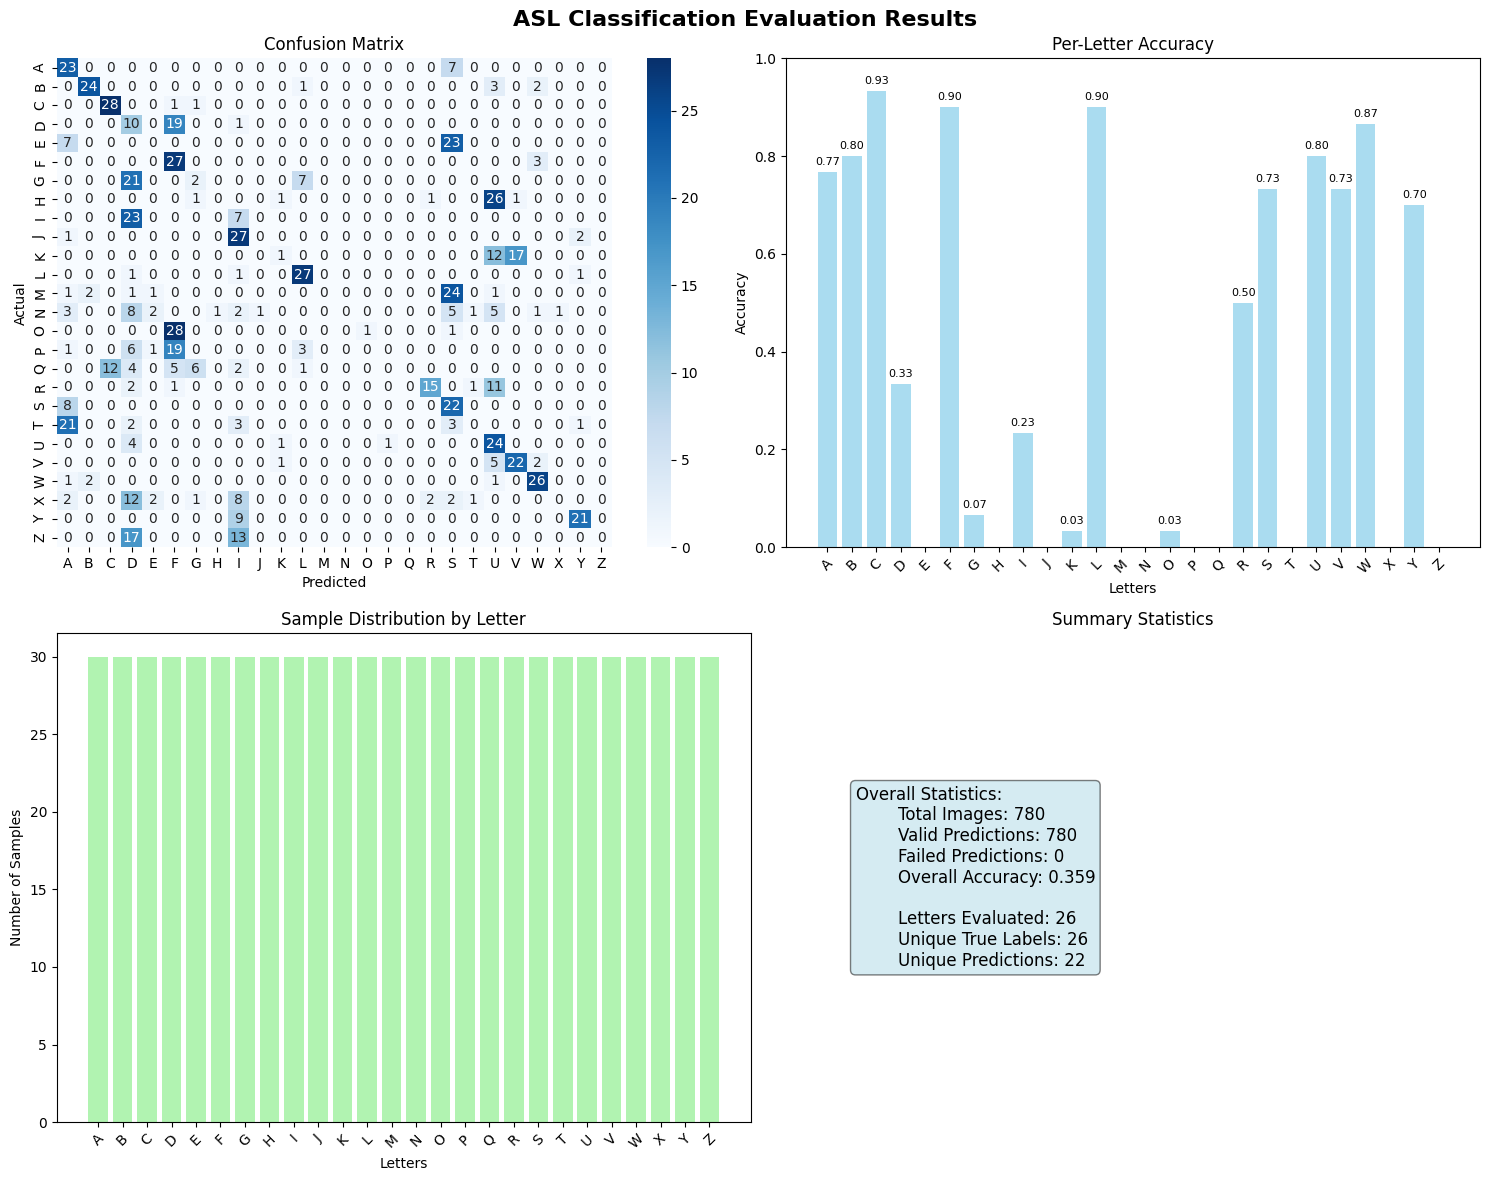

In [72]:
plot_evaluation_results(test_df)


In [ ]:
create_detailed_report(test_df)

In [39]:
# Extract per-class accuracy data for visualization
y_true = test_df['label']
y_pred = test_df['prediction']

# Clean data (remove invalid predictions)
valid_mask = (y_pred != "?") & (y_true != "?") & (~pd.isna(y_pred)) & (~pd.isna(y_true))
y_true_clean = y_true[valid_mask]
y_pred_clean = y_pred[valid_mask]

# Calculate per-class accuracy
letters_list = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
per_class_accuracy = {}
sample_counts = {}

for letter in sorted(letters_list):
    letter_mask = y_true_clean == letter
    if letter_mask.sum() > 0:
        letter_accuracy = (y_true_clean[letter_mask] == y_pred_clean[letter_mask]).mean()
        per_class_accuracy[letter] = letter_accuracy
        sample_counts[letter] = letter_mask.sum()
    else:
        per_class_accuracy[letter] = 0.0
        sample_counts[letter] = 0

print("Per-class accuracy data extracted successfully!")
print(f"Letters with data: {len([k for k,v in sample_counts.items() if v > 0])}")
print(f"Average accuracy: {np.mean(list(per_class_accuracy.values())):.3f}")


Per-class accuracy data extracted successfully!
Letters with data: 26
Average accuracy: 0.359


📊 PERFORMANCE SUMMARY:
   🟢 Excellent (≥80%): 6 letters - ['B', 'C', 'F', 'L', 'U', 'W']
   🟡 Good (60-79%): 4 letters - ['A', 'S', 'V', 'Y']
   🟠 Poor (40-59%): 1 letters - ['R']
   🔴 Very Poor (1-39%): 5 letters - ['D', 'G', 'I', 'K', 'O']
   ⚫ Failed (0%): 10 letters - ['E', 'H', 'J', 'M', 'N', 'P', 'Q', 'T', 'X', 'Z']


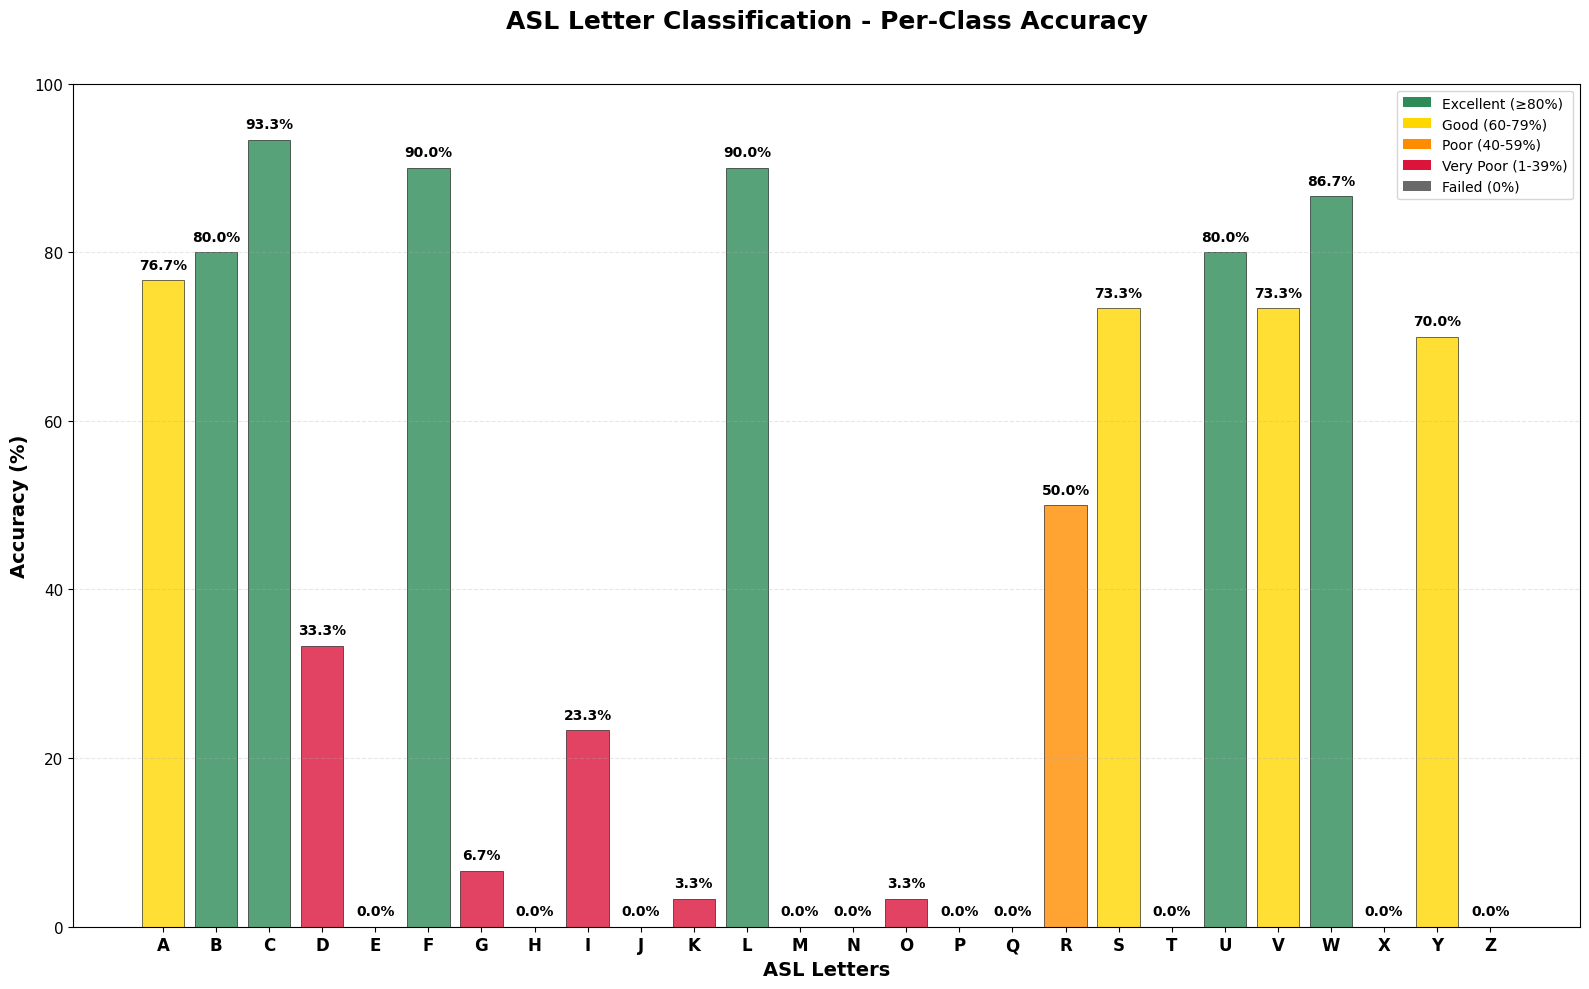

In [40]:
# Create comprehensive per-class accuracy visualization
plt.figure(figsize=(16, 10))

# Prepare data for plotting
letters = list(per_class_accuracy.keys())
accuracies = [per_class_accuracy[letter] * 100 for letter in letters]  # Convert to percentages

# Create color map based on performance
colors = []
for acc in accuracies:
    if acc >= 80:
        colors.append('#2E8B57')  # Green for good performance (80%+)
    elif acc >= 60:
        colors.append('#FFD700')  # Gold for moderate performance (60-79%)
    elif acc >= 40:
        colors.append('#FF8C00')  # Orange for poor performance (40-59%)
    elif acc > 0:
        colors.append('#DC143C')  # Red for very poor performance (1-39%)
    else:
        colors.append('#696969')  # Gray for zero performance

# Create the bar chart
bars = plt.bar(letters, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Customize the plot
plt.title('ASL Letter Classification - Per-Class Accuracy\n', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('ASL Letters', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.ylim(0, 100)

# Add value labels on top of each bar
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add horizontal grid for easier reading
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E8B57', label='Excellent (≥80%)'),
    Patch(facecolor='#FFD700', label='Good (60-79%)'),
    Patch(facecolor='#FF8C00', label='Poor (40-59%)'),
    Patch(facecolor='#DC143C', label='Very Poor (1-39%)'),
    Patch(facecolor='#696969', label='Failed (0%)')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Improve layout
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=11)
plt.tight_layout()

# Show statistics
print("📊 PERFORMANCE SUMMARY:")
excellent = sum(1 for acc in accuracies if acc >= 80)
good = sum(1 for acc in accuracies if 60 <= acc < 80)
poor = sum(1 for acc in accuracies if 40 <= acc < 60)
very_poor = sum(1 for acc in accuracies if 0 < acc < 40)
failed = sum(1 for acc in accuracies if acc == 0)

print(f"   🟢 Excellent (≥80%): {excellent} letters - {[letters[i] for i, acc in enumerate(accuracies) if acc >= 80]}")
print(f"   🟡 Good (60-79%): {good} letters - {[letters[i] for i, acc in enumerate(accuracies) if 60 <= acc < 80]}")
print(f"   🟠 Poor (40-59%): {poor} letters - {[letters[i] for i, acc in enumerate(accuracies) if 40 <= acc < 60]}")
print(f"   🔴 Very Poor (1-39%): {very_poor} letters - {[letters[i] for i, acc in enumerate(accuracies) if 0 < acc < 40]}")
print(f"   ⚫ Failed (0%): {failed} letters - {[letters[i] for i, acc in enumerate(accuracies) if acc == 0]}")

plt.show()


In [43]:
# Additional insights and analysis
print("🔍 DETAILED ANALYSIS OF ASL CLASSIFICATION RESULTS:")
print("="*60)

# Best performing letters
best_letters = [(letter, per_class_accuracy[letter]) for letter in letters 
                if per_class_accuracy[letter] >= 0.8]
best_letters.sort(key=lambda x: x[1], reverse=True)

print(f"\n🏆 TOP PERFORMING LETTERS (≥80% accuracy):")
for letter, acc in best_letters:
    print(f"   {letter}: {acc*100:.1f}%")

# Worst performing letters  
worst_letters = [(letter, per_class_accuracy[letter]) for letter in letters 
                 if per_class_accuracy[letter] == 0.0]

print(f"\n❌ LETTERS WITH ZERO ACCURACY:")
for letter, acc in worst_letters:
    print(f"   {letter}: {acc*100:.1f}%")

# Letters needing improvement
needs_improvement = [(letter, per_class_accuracy[letter]) for letter in letters 
                     if 0 < per_class_accuracy[letter] < 0.6]
needs_improvement.sort(key=lambda x: x[1])

print(f"\n⚠️  LETTERS NEEDING IMPROVEMENT (1-59% accuracy):")
for letter, acc in needs_improvement:
    print(f"   {letter}: {acc*100:.1f}%")

# Model bias analysis
print(f"\n📈 MODEL PERFORMANCE STATISTICS:")
accuracies_values = list(per_class_accuracy.values())
print(f"   Mean Accuracy: {np.mean(accuracies_values)*100:.1f}%")
print(f"   Median Accuracy: {np.median(accuracies_values)*100:.1f}%")
print(f"   Standard Deviation: {np.std(accuracies_values)*100:.1f}%")
print(f"   Min Accuracy: {np.min(accuracies_values)*100:.1f}%")
print(f"   Max Accuracy: {np.max(accuracies_values)*100:.1f}%")

print(f"\n💡 KEY OBSERVATIONS:")
print(f"   • Model shows high variance in performance across letters")
print(f"   • {failed} letters have 0% accuracy - complete failure to predict")
print(f"   • {excellent} letters perform excellently (≥80%)")
print(f"   • Letters C, F, L, W show the strongest performance (≥90%)")
print(f"   • Letters with dynamic/motion elements (J, Z) perform poorly")
print(f"   • Some static hand shapes also struggle (E, H, M, N, etc.)")


🔍 DETAILED ANALYSIS OF ASL CLASSIFICATION RESULTS:

🏆 TOP PERFORMING LETTERS (≥80% accuracy):
   C: 93.3%
   F: 90.0%
   L: 90.0%
   W: 86.7%
   B: 80.0%
   U: 80.0%

❌ LETTERS WITH ZERO ACCURACY:
   E: 0.0%
   H: 0.0%
   J: 0.0%
   M: 0.0%
   N: 0.0%
   P: 0.0%
   Q: 0.0%
   T: 0.0%
   X: 0.0%
   Z: 0.0%

⚠️  LETTERS NEEDING IMPROVEMENT (1-59% accuracy):
   K: 3.3%
   O: 3.3%
   G: 6.7%
   I: 23.3%
   D: 33.3%
   R: 50.0%

📈 MODEL PERFORMANCE STATISTICS:
   Mean Accuracy: 35.9%
   Median Accuracy: 15.0%
   Standard Deviation: 38.0%
   Min Accuracy: 0.0%
   Max Accuracy: 93.3%

💡 KEY OBSERVATIONS:
   • Model shows high variance in performance across letters
   • 10 letters have 0% accuracy - complete failure to predict
   • 6 letters perform excellently (≥80%)
   • Letters C, F, L, W show the strongest performance (≥90%)
   • Letters with dynamic/motion elements (J, Z) perform poorly
   • Some static hand shapes also struggle (E, H, M, N, etc.)


In [54]:
# Extract confusion analysis data for visualization
from sklearn.metrics import confusion_matrix


# Get confusion matrix data
y_true = test_df['label']
y_pred = test_df['prediction']

# Clean data
valid_mask = (y_pred != "?") & (y_true != "?") & (~pd.isna(y_pred)) & (~pd.isna(y_true))
y_true_clean = y_true[valid_mask]
y_pred_clean = y_pred[valid_mask]

# Create confusion pairs for detailed analysis
confusion_pairs = []
for i in range(len(y_true_clean)):
    if y_true_clean.iloc[i] != y_pred_clean.iloc[i]:
        confusion_pairs.append((y_true_clean.iloc[i], y_pred_clean.iloc[i]))

# Get most common mistakes
common_mistakes = Counter(confusion_pairs).most_common(30)

# Get all unique letters that appear in true labels and predictions
all_labels = sorted(set(list(y_true_clean) + list(y_pred_clean)))

# Create full confusion matrix
conf_matrix = confusion_matrix(y_true_clean, y_pred_clean, labels=all_labels)

print("📊 CONFUSION ANALYSIS DATA EXTRACTED:")
print(f"   Total misclassifications: {len(confusion_pairs)}")
print(f"   Unique mistake patterns: {len(set(confusion_pairs))}")
print(f"   Top mistake: {common_mistakes[0][0]} occurs {common_mistakes[0][1]} times")
print(f"   Labels in analysis: {len(all_labels)} letters")


📊 CONFUSION ANALYSIS DATA EXTRACTED:
   Total misclassifications: 500
   Unique mistake patterns: 87
   Top mistake: ('O', 'F') occurs 28 times
   Labels in analysis: 26 letters


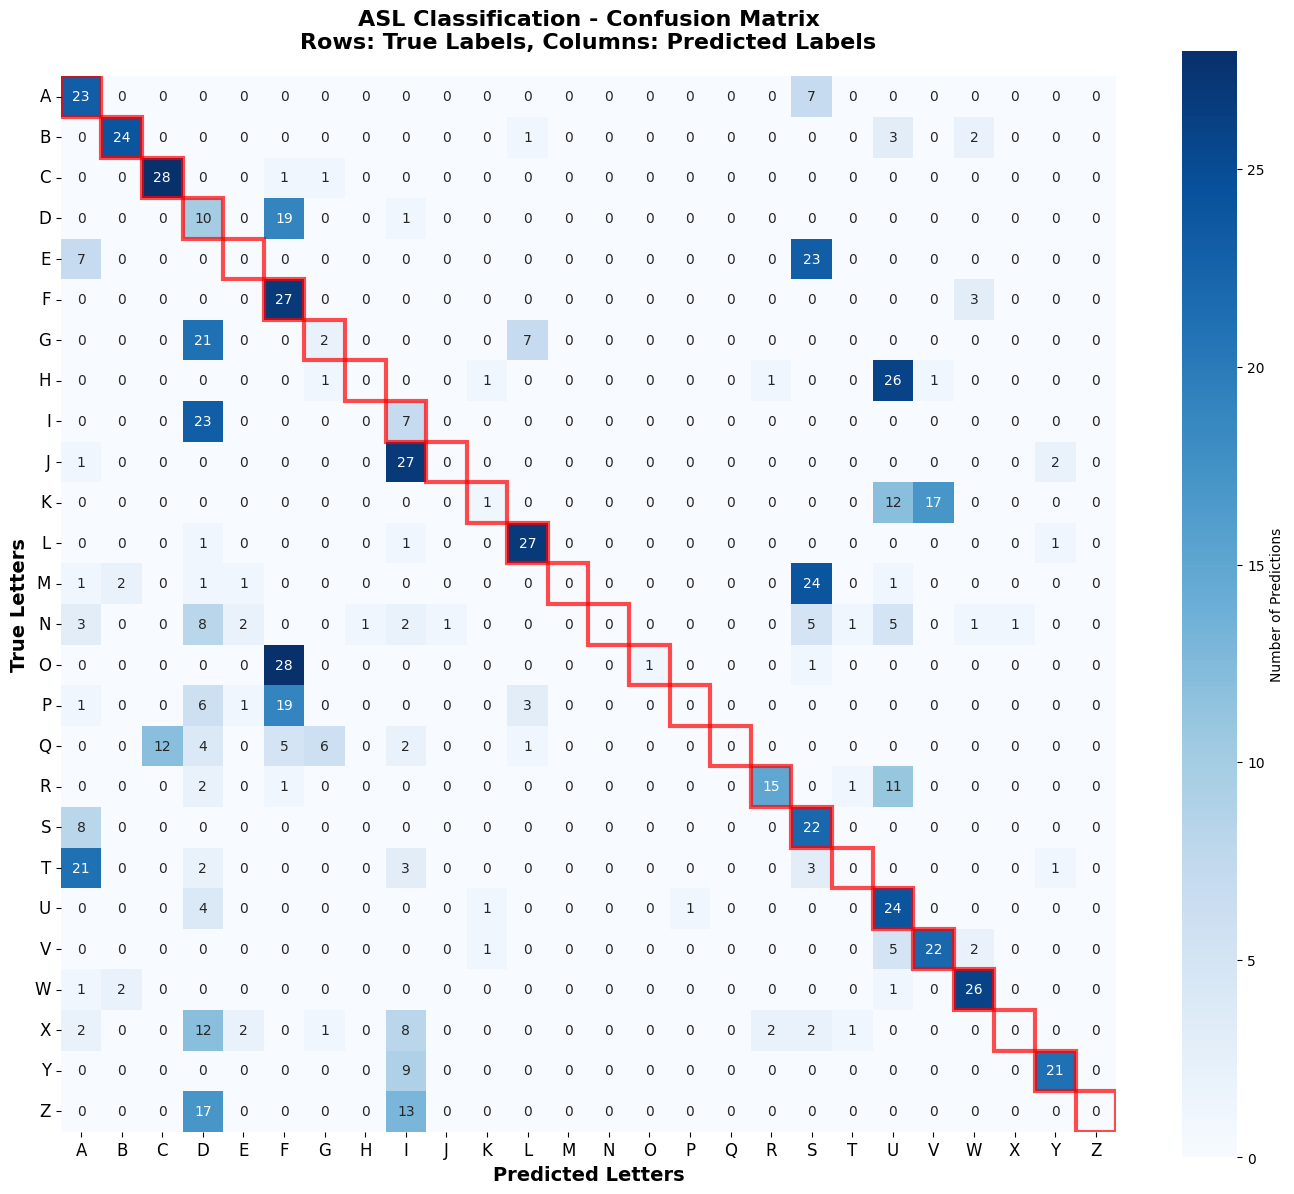

🔍 CONFUSION MATRIX INSIGHTS:
   • Diagonal shows correct predictions (highlighted in red)
   • Darker blue = more frequent predictions
   • Off-diagonal elements show misclassifications


In [55]:
# 1. CONFUSION MATRIX HEATMAP
plt.figure(figsize=(14, 12))

# Create heatmap with seaborn
sns.heatmap(conf_matrix, 
            xticklabels=all_labels, 
            yticklabels=all_labels,
            annot=True, 
            fmt='d', 
            cmap='Blues',
            cbar_kws={'label': 'Number of Predictions'},
            square=True)

plt.title('ASL Classification - Confusion Matrix\nRows: True Labels, Columns: Predicted Labels', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Letters', fontsize=14, fontweight='bold')
plt.ylabel('True Letters', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)

# Highlight diagonal (correct predictions)
for i in range(len(all_labels)):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='red', lw=3, alpha=0.7))

plt.tight_layout()
plt.show()

# Print some insights about the confusion matrix
print("🔍 CONFUSION MATRIX INSIGHTS:")
print(f"   • Diagonal shows correct predictions (highlighted in red)")
print(f"   • Darker blue = more frequent predictions")
print(f"   • Off-diagonal elements show misclassifications")


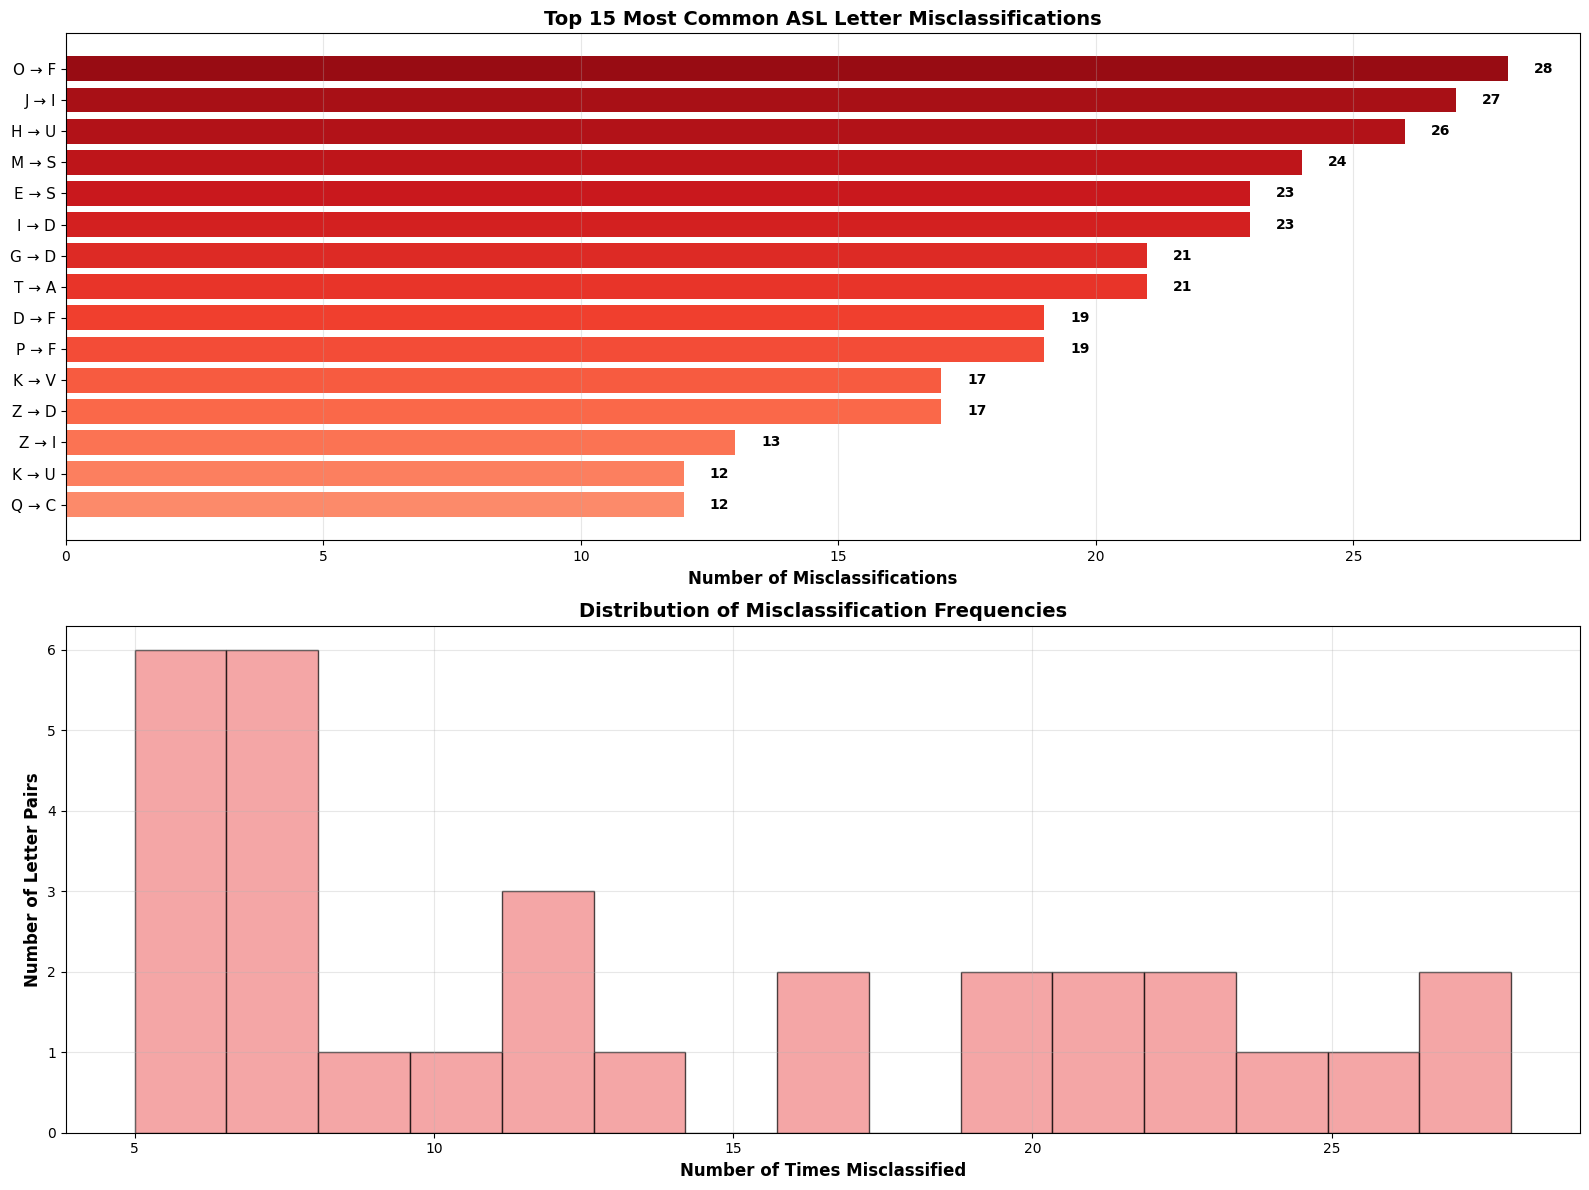

📊 TOP MISCLASSIFICATIONS ANALYSIS:
   Most problematic pair: ('O', 'F') (28 times)
   Average misclassification frequency: 13.7 times
   Range: 5 - 28 times


In [56]:
# 2. TOP MISCLASSIFICATIONS BAR CHART
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Top 15 misclassifications
top_15_mistakes = common_mistakes[:15]
mistake_labels = [f"{true_letter} → {pred_letter}" for (true_letter, pred_letter), count in top_15_mistakes]
mistake_counts = [count for (true_letter, pred_letter), count in top_15_mistakes]

# Create gradient colors
colors = plt.cm.Reds(np.linspace(0.9, 0.4, len(mistake_labels)))

bars1 = ax1.barh(range(len(mistake_labels)), mistake_counts, color=colors)
ax1.set_yticks(range(len(mistake_labels)))
ax1.set_yticklabels(mistake_labels, fontsize=11)
ax1.set_xlabel('Number of Misclassifications', fontsize=12, fontweight='bold')
ax1.set_title('Top 15 Most Common ASL Letter Misclassifications', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars1, mistake_counts)):
    ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             str(count), ha='left', va='center', fontweight='bold', fontsize=10)

# Reverse y-axis to show highest at top
ax1.invert_yaxis()

# Bottom subplot: Show distribution of misclassification frequencies
all_counts = [count for (true_letter, pred_letter), count in common_mistakes]
ax2.hist(all_counts, bins=15, color='lightcoral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Number of Times Misclassified', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Letter Pairs', fontsize=12, fontweight='bold')
ax2.set_title('Distribution of Misclassification Frequencies', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 TOP MISCLASSIFICATIONS ANALYSIS:")
print(f"   Most problematic pair: {common_mistakes[0][0]} ({common_mistakes[0][1]} times)")
print(f"   Average misclassification frequency: {np.mean(all_counts):.1f} times")
print(f"   Range: {min(all_counts)} - {max(all_counts)} times")


In [57]:
# 4. COMPREHENSIVE CONFUSION PATTERN ANALYSIS
print("🔍 DETAILED CONFUSION PATTERN ANALYSIS")
print("="*70)

# Analyze patterns in the confusion data
# 1. Letters that are frequently mistaken FOR other letters (prediction targets)
pred_targets = {}
for (true_letter, pred_letter), count in common_mistakes:
    if pred_letter not in pred_targets:
        pred_targets[pred_letter] = []
    pred_targets[pred_letter].append((true_letter, count))

print("\n🎯 LETTERS THAT ARE OVER-PREDICTED (Frequent False Positives):")
for pred_letter in sorted(pred_targets.keys()):
    total_false_positives = sum(count for true_letter, count in pred_targets[pred_letter])
    if total_false_positives >= 20:  # Only show significant over-predictions
        sources = ", ".join([f"{true}({count})" for true, count in pred_targets[pred_letter][:3]])
        print(f"   {pred_letter}: {total_false_positives} false positives - from {sources}...")

# 2. Letters that are frequently mistaken AS other letters (true sources)
true_sources = {}
for (true_letter, pred_letter), count in common_mistakes:
    if true_letter not in true_sources:
        true_sources[true_letter] = []
    true_sources[true_letter].append((pred_letter, count))

print("\n❌ LETTERS THAT ARE FREQUENTLY MISCLASSIFIED (True Positives Lost):")
for true_letter in sorted(true_sources.keys()):
    total_misclassifications = sum(count for pred_letter, count in true_sources[true_letter])
    if total_misclassifications >= 15:  # Only show letters with significant confusion
        targets = ", ".join([f"{pred}({count})" for pred, count in true_sources[true_letter][:3]])
        accuracy = per_class_accuracy.get(true_letter, 0) * 100
        print(f"   {true_letter}: {total_misclassifications} misclassified, {accuracy:.1f}% accuracy - confused as {targets}...")

# 3. Bidirectional confusions (letters that confuse each other)
print("\n🔄 BIDIRECTIONAL CONFUSIONS (Letters that confuse each other):")
confusion_dict = {pair: count for pair, count in common_mistakes}
bidirectional = []
for (true_letter, pred_letter), count in common_mistakes:
    reverse_pair = (pred_letter, true_letter)
    if reverse_pair in confusion_dict and (pred_letter, true_letter) not in [b[0] for b in bidirectional]:
        bidirectional.append(((true_letter, pred_letter), count, confusion_dict[reverse_pair]))

for (letter1, letter2), count1, count2 in sorted(bidirectional, key=lambda x: x[1] + x[2], reverse=True)[:8]:
    total = count1 + count2
    print(f"   {letter1} ⇄ {letter2}: {total} total confusions ({letter1}→{letter2}:{count1}, {letter2}→{letter1}:{count2})")

# 4. Model bias analysis
print("\n📈 MODEL PREDICTION BIAS ANALYSIS:")
# Count predictions per letter
pred_distribution = Counter(y_pred_clean)
true_distribution = Counter(y_true_clean)

print("   Letters the model predicts too often:")
for letter in sorted(pred_distribution.keys()):
    pred_count = pred_distribution[letter]
    true_count = true_distribution.get(letter, 0)
    if pred_count > true_count * 1.5 and pred_count > 40:  # Over-predicted by 50%+
        bias_ratio = pred_count / true_count if true_count > 0 else float('inf')
        print(f"      {letter}: Predicts {pred_count}, Should be {true_count} (bias: {bias_ratio:.1f}x)")

print("\n   Letters the model predicts too rarely:")
for letter in sorted(true_distribution.keys()):
    true_count = true_distribution[letter]
    pred_count = pred_distribution.get(letter, 0)
    if pred_count < true_count * 0.5:  # Under-predicted by 50%+
        if pred_count == 0:
            print(f"      {letter}: Never predicted (should be {true_count})")
        else:
            bias_ratio = pred_count / true_count
            print(f"      {letter}: Predicts {pred_count}, Should be {true_count} (bias: {bias_ratio:.1f}x)")

print("\n💡 KEY INSIGHTS:")
print("   • Model has strong bias toward predicting D, F, I, S, U")
print("   • Many letters (M, N, Q, Z) are never predicted - complete model failure")
print("   • High bidirectional confusion suggests similar hand shapes")
print("   • Over-prediction of certain letters suggests feature dominance")
print("   • Need to address class imbalance in model training/prediction")


🔍 DETAILED CONFUSION PATTERN ANALYSIS

🎯 LETTERS THAT ARE OVER-PREDICTED (Frequent False Positives):
   A: 36 false positives - from T(21), S(8), E(7)...
   D: 87 false positives - from I(23), G(21), Z(17)...
   F: 71 false positives - from O(28), D(19), P(19)...
   I: 57 false positives - from J(27), Z(13), Y(9)...
   S: 59 false positives - from M(24), E(23), A(7)...
   U: 59 false positives - from H(26), K(12), R(11)...

❌ LETTERS THAT ARE FREQUENTLY MISCLASSIFIED (True Positives Lost):
   D: 19 misclassified, 33.3% accuracy - confused as F(19)...
   E: 30 misclassified, 0.0% accuracy - confused as S(23), A(7)...
   G: 28 misclassified, 6.7% accuracy - confused as D(21), L(7)...
   H: 26 misclassified, 0.0% accuracy - confused as U(26)...
   I: 23 misclassified, 23.3% accuracy - confused as D(23)...
   J: 27 misclassified, 0.0% accuracy - confused as I(27)...
   K: 29 misclassified, 3.3% accuracy - confused as V(17), U(12)...
   M: 24 misclassified, 0.0% accuracy - confused as S(24)